<a href="https://colab.research.google.com/github/jairomartinezgiraldo/CNN/blob/main/CNNVIERNES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importar librerías necesarias
import os
from google.colab import files
from google.colab import drive
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # Importar los callbacks

# Carga - Conectar Google Drive y Descargar el Dataset


In [2]:

# Descargar el dataset de Yoga desde Kaggle
!kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset

# Descomprimir el archivo descargado
import zipfile
with zipfile.ZipFile('yoga-posture-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/yoga_dataset')

print("Dataset descargado y extraído exitosamente.")


Dataset URL: https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset
License(s): CC0-1.0
 99% 444M/447M [00:20<00:00, 21.5MB/s]
100% 447M/447M [00:20<00:00, 22.7MB/s]
Dataset descargado y extraído exitosamente.


In [15]:

# Montamos Google Drive para el almacenamiento del modelo y resultado.
drive.mount('/content/drive')

# Definimos la ruta del dataset y la estructura de carpetas en Google Drive
base_dir = '/content/yoga_dataset'
drive_dir = '/content/drive/MyDrive/yoga_pose_classification'

# Creamos las carpetas en Google Drive para almacenar los resultados y el mejor modelo
os.makedirs(drive_dir, exist_ok=True)
os.makedirs(f"{drive_dir}/results", exist_ok=True)
os.makedirs(f"{drive_dir}/models", exist_ok=True)
                          #__________________________________________________________________________________esta parte es nueva, creamos un
# Confirmamos la estructura de carpetas
print("Estructura de carpetas:")
print(f"Dataset en: {base_dir}")
print(f"Resultados en: {drive_dir}/results")
print(f"Modelos en: {drive_dir}/models")#


Estructura de carpetas:
Dataset en: /content/yoga_dataset
Resultados en: /content/drive/MyDrive/yoga_pose_classification/results
Modelos en: /content/drive/MyDrive/yoga_pose_classification/models


# Inspección - Análisis del dataset



*   Verificación de las subcarpetas del dataset, observando las diferentes clases de posturas de yoga.
*   Cada clase tiene un numero distinto de imagenes.
* A partir del dataset identificar y reconocer las distintas poses de yoga.



In [16]:
subfolders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(f"Total de clases: {len(subfolders)}")
print("Clases encontradas:", subfolders)

Total de clases: 47
Clases encontradas: ['Ardha Chandrasana', 'Dhanurasana', 'Pincha Mayurasana', 'Trikonasana', 'Eka Pada Rajakapotasana', 'Virabhadrasana Two', 'Sivasana', 'Utkatasana', 'Garudasana', 'Baddha Konasana', 'Salamba Bhujangasana', 'Halasana', 'Utthita Hasta Padangusthasana', 'Bakasana', 'Virabhadrasana Three', 'Navasana', 'Urdhva Dhanurasana', 'Setu Bandha Sarvangasana', 'Uttanasana', 'Padmasana', 'Adho Mukha Svanasana', 'Utthita Parsvakonasana', 'Ardha Pincha Mayurasana', 'Ashta Chandrasana', 'Urdhva Mukha Svsnssana', 'Camatkarasana', 'Malasana', 'Paschimottanasana', 'Parsvottanasana', 'Ustrasana', 'Balasana', 'Anjaneyasana', 'Vasisthasana', 'Ardha Navasana', 'Adho Mukha Vrksasana', 'Hanumanasana', 'Ardha Matsyendrasana', 'Vrksasana', 'Upavistha Konasana', 'Supta Kapotasana', 'Phalakasana', 'Virabhadrasana One', 'Salamba Sarvangasana', 'Marjaryasana', 'Bitilasana', 'Parsva Virabhadrasana', 'Alanasana']


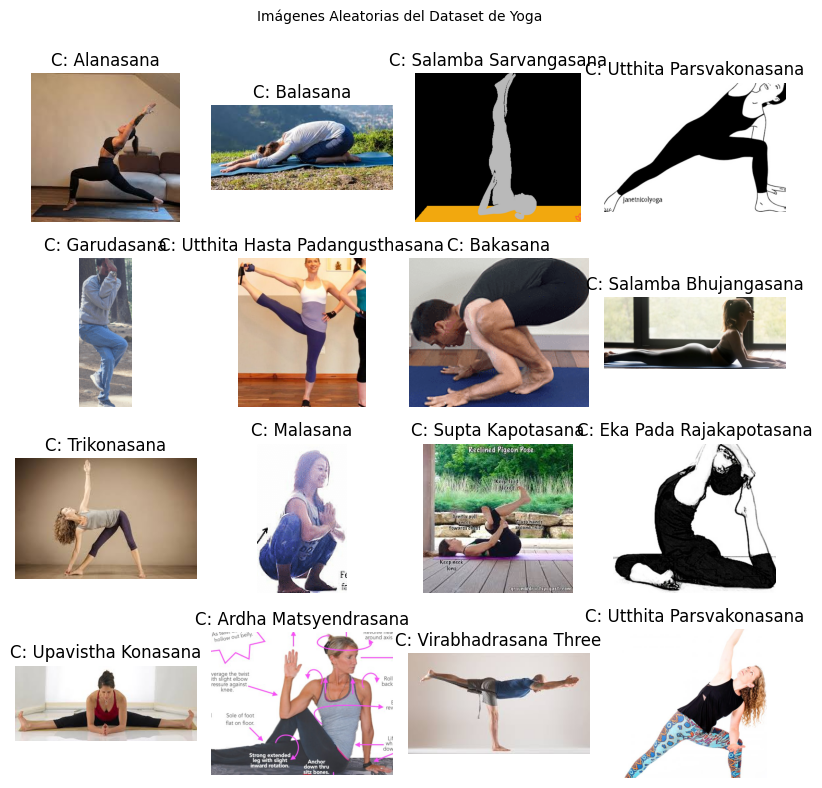

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Imágenes Aleatorias del Dataset de Yoga', fontsize=10)

for ax in axes.flatten():
    chosen_folder = np.random.choice(subfolders)
    subfolder_path = os.path.join(base_dir, chosen_folder)

    # Verificar que la carpeta contiene imágenes, podemos observar distintos formatos de imagenes.
    images = [img for img in os.listdir(subfolder_path) if img.endswith(('.png', '.jpeg', '.jpg'))]
    if not images:  # Si la carpeta está vacía o no tiene imágenes, salta esta iteración
        ax.set_title('Sin imágenes')
        ax.axis('off')
        continue

    # Seleccionamos imagenes aleatoria para verificar la correcta carga de imagenes.
    img_name = np.random.choice(images)
    img_path = os.path.join(subfolder_path, img_name)

    # Mostramos las imagenes.
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"C: {chosen_folder}")
    else:
        ax.set_title('Imagen no encontrada')
        ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Acondicionamiento - preprocesamiento de imágenes



* Configuración de ImageDataGenerator para Entrenamiento, Validación y Prueba
* Habilitamos generadores de datos para entrenamiento y validación





In [6]:
# Tamaño de imagen ajustado para MobileNetV2
IMG_SIZE = (224, 224)

# Configuración del aumento de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # Dividir el dataset en 70% entrenamiento y 30% (para validación y prueba)
)

# Generador de datos para el conjunto de entrenamiento (70% del total)
# Usamos flow_from_directory mejorar la eficiencia
train_generator = train_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    color_mode='rgb'  # RGB para MobileNetV2
)

# Generador de datos para el conjunto de validación (15% del total)
val_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.5)
val_generator = val_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'
)

# Generador de datos para el conjunto de prueba (15% del total)
test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.5)
test_generator = test_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    shuffle=False  # Matener orden de las clases
)

Found 1953 images belonging to 47 classes.
Found 1366 images belonging to 47 classes.
Found 1366 images belonging to 47 classes.


# Definición de callbacks - Transfer Learning - MobileNetV2


*   EarlyStopping: Detener el entrenamiento si no hay mejoras.
*   ModelCheckpoint: Guardar el mejor modelo en Google Drive.
*  ReduceLROnPlateau: Ajustar la tasa de aprendizaje automáticamente para una mejor convergencia.



In [ ]:
#----------------------------------------------------------------------------------------------------------------toda esta parte es nueva
model_path = '/content/drive/MyDrive/yoga_pose_classification/best_yoga_pose_model.keras'

# Early Stopping, ventaja evitar sobreajuste, si no mejora detiene el proceso.

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
# Model Checkpointing guarda el mejor modelo,
# permitiendo recuperarlo para futuras predicciones o continuar el entrenamiento.

model_checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# ReduceLROnPlateau reduce la tasa de aprendizaje cuando el modelo deja de mejorar,
# ayudando al modelo a converger de manera más fina.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

# Desarrollo de la arquitectura - Transfer Learning - MobileNetV2

Usamos **MobileNetV2** por su excelente balance entre precisión y velocidad, que ya ha sido entrenada en millones de imágenes (de ImageNet). Esto significa que MovilnetV2 ya ha aprendido muchas características útiles para reconocer objetos.

En las capas adicionales iniciamos con el modelo base y aplicamos Flatten para transformar los datos en una sola dimensión. Agregamos una capa densa con 256 neuronas y activación ReLU, esto ayudará al modelo a aprender patrones complejos de clasificación. Para evitar el sobreajuste aplicamos regularización L2 y BatchNormalization, lo cual estabiliza el entrenamiento al normalizar las activaciones en cada capa. También incorporamos Dropout al 50%, lo que desconecta la mitad de las neuronas de forma aleatoria en cada paso de entrenamiento, ayudando a que el modelo generalice mejor. Finalmente, la última capa es otra capa densa con activación softmax, que devuelve la probabilidad de cada una de las 47 poses de yoga, permitiendo al modelo clasificar múltiples categorías.



In [ ]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar el modelo base para el primer entrenamiento

# Construir las capas adicionales para la clasificación
x = base_model.output
x = layers.Flatten()(x)  # Utilizar Flatten para conservar toda la información espacial
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(47, activation='softmax')(x)  # 47 clases de poses de yoga

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento inicial
history_aug = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Suficientes épocas para observar convergencia en Transfer Learning
    callbacks=callbacks ##### ----------------------------------------------------------------------------------------------------------esta parte es nueva. ---------------------------
)

Epoch 1/15
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.1077 - loss: 9.8724
Epoch 1: val_accuracy improved from -inf to 0.44510, saving model to /content/drive/MyDrive/yoga_pose_classification/best_yoga_pose_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 59s 774ms/step - accuracy: 0.1096 - loss: 9.8591 - val_accuracy: 0.4451 - val_loss: 7.3813 - learning_rate: 0.0010
Epoch 2/15
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.3675 - loss: 6.9185
Epoch 2: val_accuracy improved from 0.44510 to 0.62518, saving model to /content/drive/MyDrive/yoga_pose_classification/best_yoga_pose_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 628ms/step - accuracy: 0.3676 - loss: 6.9050 - val_accuracy: 0.6252 - val_loss: 5.0389 - learning_rate: 0.0010
Epoch 3/15
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.4328 - loss: 5.4912
Epoch 3: val_accuracy improved from 0.62518 to 0.67936, saving model to /content/drive/MyDrive/yoga_pose_classification/best_yoga_pose_model.keras
62/62 ━━━━━━━━━━━━━━

# Evaluación y Graficación de Métricas- Transfer Learning - MobileNetV2

Una vez completado el primer entrenamiento, evaluaremos las métricas de precisión y pérdida para ver cómo ha aprendido el modelo hasta ahora.

In [ ]:
# Evaluación en Transfer Learning
results_transfer = model.evaluate(test_generator, verbose=0)
print("    Test Loss (Transfer Learning): {:.5f}".format(results_transfer[0]))
print("Test Accuracy (Transfer Learning): {:.2f}%".format(results_transfer[1] * 100))

# Predicción y reporte de clasificación
predictions_transfer = model.predict(test_generator, batch_size=128)
print("Reporte de Clasificación - Transfer Learning:")
print(classification_report(test_generator.classes, predictions_transfer.argmax(axis=1), target_names=test_generator.class_indices.keys()))

    Test Loss (Transfer Learning): 2.48308
Test Accuracy (Transfer Learning): 75.84%
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step
Reporte de Clasificación - Transfer Learning:
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.75      0.89      0.81        37
         Adho Mukha Vrksasana       0.83      0.78      0.81        32
                    Alanasana       0.80      0.44      0.57         9
                 Anjaneyasana       0.78      0.60      0.68        35
            Ardha Chandrasana       0.77      0.79      0.78        29
         Ardha Matsyendrasana       0.73      0.77      0.75        48
               Ardha Navasana       1.00      0.83      0.91         6
      Ardha Pincha Mayurasana       0.75      0.78      0.76        27
            Ashta Chandrasana       0.57      0.67      0.62         6
              Baddha Konasana       0.47      0.78      0.58        40
                     Bakasana       0.97     

**Reporte de Clasificación**
* Precisión Global: El conjunto de prueba es del 75%, es un buen resultado para multiclases
* Métricas por Clase:
las clase Adho Mukha Svanasana y Ardha Navasana, tienen métricas más bajas en términos de precisión y recall, al modelo se le dificulta identicar estas poses.
* Otras clases, como Dhanurasana y Supta Kapotasana, muestran métricas muy altas (con precisión y recall cerca de 1.0), lo que sugiere que el modelo tiene más facilidad para reconocer estas poses.
* Macro y Weighted Averages: la precisión macro es de 0.81, el modelo tiene un buen desempeño en la mayoría de las clases.


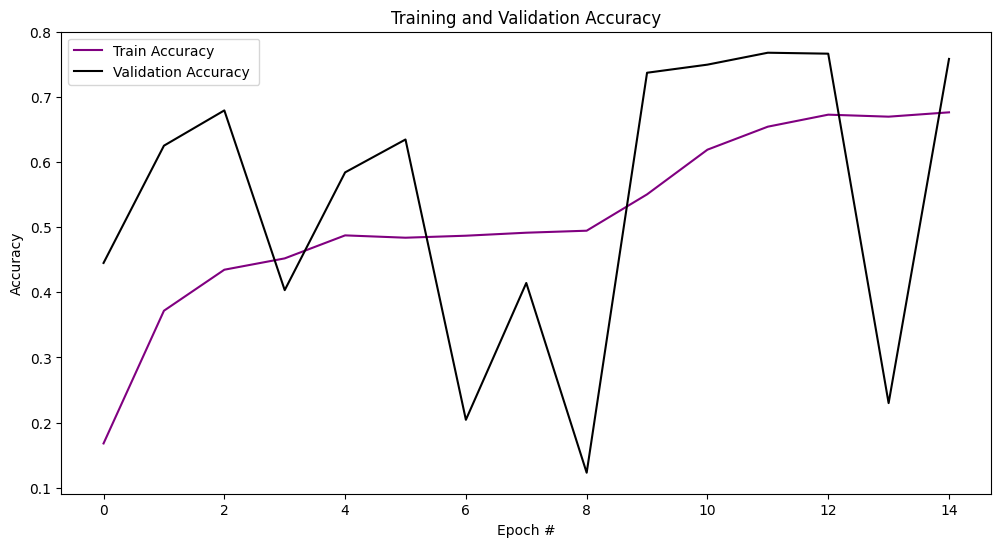

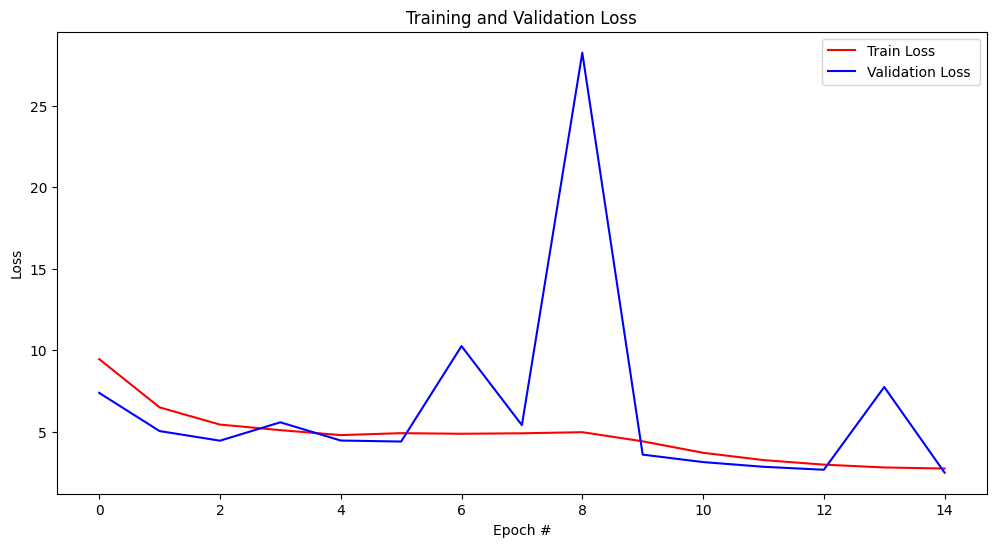

In [ ]:
# Graficar Accuracy de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(history_aug.history["accuracy"], label="Train Accuracy ", color='purple')
plt.plot(history_aug.history["val_accuracy"], label="Validation Accuracy ", color='black')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Graficar Loss de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(history_aug.history["loss"], label="Train Loss ", color='red')
plt.plot(history_aug.history["val_loss"], label="Validation Loss ", color='blue')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()




# Desarrollo de la arquitectura - Fine-Tuning - MobileNetV2

Ahora vamos a realizar Fine-Tuning , descongelaremos algunas capas para que el modelo pueda ajustar mejor las características del conjunto de datos habilitando un análisis más profundo, esto nos ayuda para evitar sobreajuste en algunos casos.

In [ ]:
# Descongelar parcialmente el modelo base
fine_tune_at = 120  # Descongelar capas a partir de la capa 120

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
base_model.trainable = True

# Compilar el modelo nuevamente con una tasa de aprendizaje menor
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento con Fine-Tuning
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks # ---------------------------------------------------------------------------------------esta parte es nueva
)


Epoch 1/10
32/62 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4625 - loss: 3.4945

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.4790 - loss: 3.4073
Epoch 1: val_accuracy did not improve from 0.76794
62/62 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.4795 - loss: 3.4049 - val_accuracy: 0.6618 - val_loss: 2.6783 - learning_rate: 1.0000e-04
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.5895 - loss: 2.7517
Epoch 2: val_accuracy did not improve from 0.76794
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 630ms/step - accuracy: 0.5897 - loss: 2.7508 - val_accuracy: 0.7467 - val_loss: 2.1733 - learning_rate: 1.0000e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.6843 - loss: 2.3334
Epoch 3: val_accuracy improved from 0.76794 to 0.77306, saving model to /content/drive/MyDrive/yoga_pose_classification/best_yoga_pose_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 87s 716ms/step - accuracy: 0.6846 - loss: 2.3325 - val_accuracy: 0.7731 - val_loss: 1.9944 - learning_rate: 1.0000e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.75


# Evaluación y Graficación de Métricas- Fine Tuning - MobileNetV2

In [ ]:
# Evaluación en Fine-Tuning
results_fine_tuning = model.evaluate(test_generator, verbose=0)
print("    Test Loss (Fine-Tuning): {:.5f}".format(results_fine_tuning[0]))
print("Test Accuracy (Fine-Tuning): {:.2f}%".format(results_fine_tuning[1] * 100))

# Predicción y reporte de clasificación en Fine-Tuning
predictions_fine = model.predict(test_generator, batch_size=128)
print("Reporte de Clasificación - Fine-Tuning:")
print(classification_report(test_generator.classes, predictions_fine.argmax(axis=1), target_names=test_generator.class_indices.keys()))


    Test Loss (Fine-Tuning): 1.49204
Test Accuracy (Fine-Tuning): 83.31%
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step
Reporte de Clasificación - Fine-Tuning:
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.94      0.78      0.85        37
         Adho Mukha Vrksasana       0.74      0.62      0.68        32
                    Alanasana       0.43      0.33      0.38         9
                 Anjaneyasana       0.65      0.69      0.67        35
            Ardha Chandrasana       0.88      0.79      0.84        29
         Ardha Matsyendrasana       0.90      0.92      0.91        48
               Ardha Navasana       0.71      0.83      0.77         6
      Ardha Pincha Mayurasana       0.91      0.74      0.82        27
            Ashta Chandrasana       1.00      0.33      0.50         6
              Baddha Konasana       0.88      0.90      0.89        40
                     Bakasana       0.83      0.95      0.89   

**Reporte de Clasificación**

* Precisión General: La precisión del modelo ha mejorado en el conjunto de prueba, alcanzando el 83.21%, un aumento significativo en comparación con la fase inicial de transfer learning.
* La mayoría de las clases tienen una buena precisión y recall, aunque algunas poses específicas todavía muestran variaciones.
* Las métricas promedio (macro avg y weighted avg) indican una buena consistencia en general, con una precisión promedio ponderada de 0.83 y un recall de 0.83, lo cual es una mejora en comparación con el modelo sin fine-tuning.

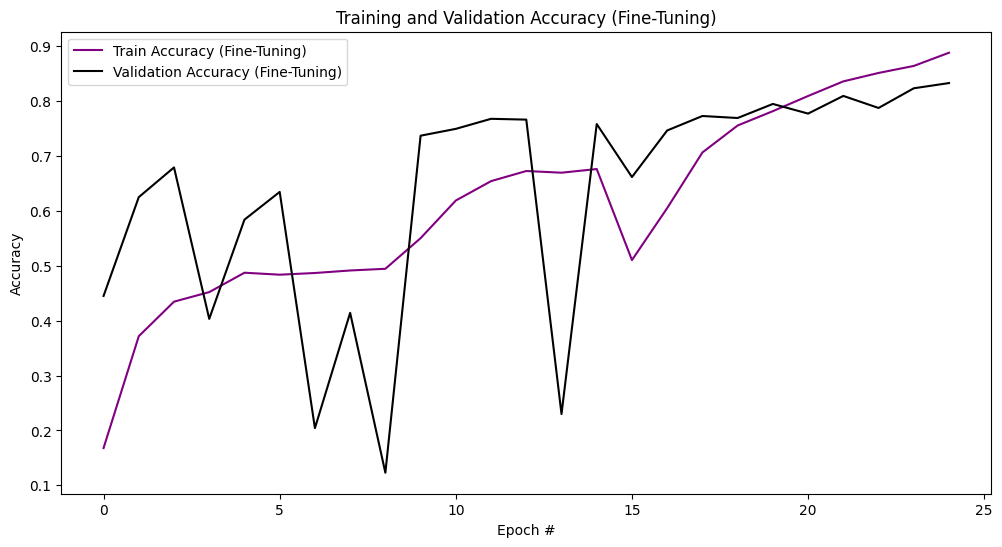

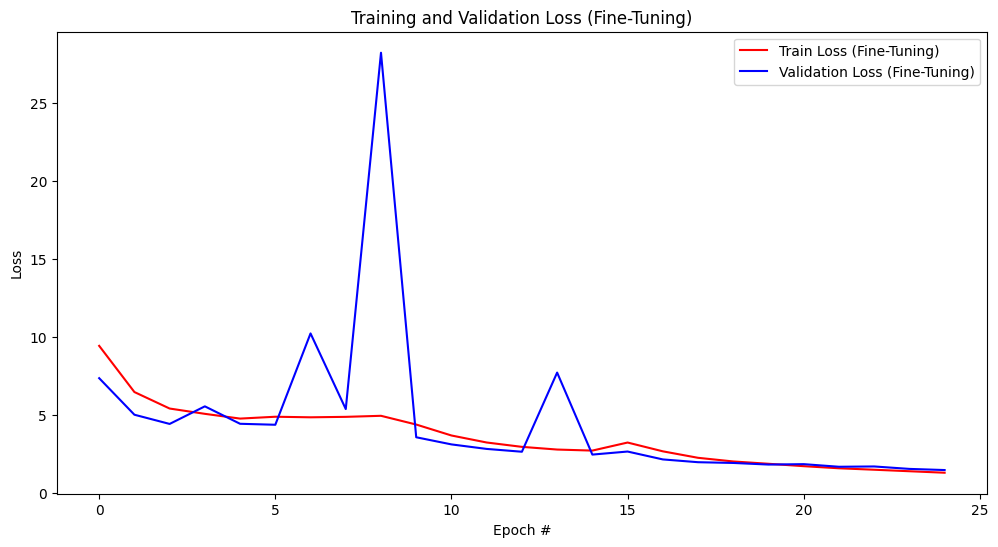

In [ ]:
# Graficar Accuracy de entrenamiento y validación de Fine-Tuning
acc = history_aug.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_aug.history['val_accuracy'] + history_fine.history['val_accuracy']
plt.figure(figsize=(12, 6))
plt.plot(range(len(acc)), acc, label='Train Accuracy (Fine-Tuning)', color='purple')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy (Fine-Tuning)', color='black')
plt.title("Training and Validation Accuracy (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Graficar Loss de entrenamiento y validación de Fine-Tuning
loss = history_aug.history['loss'] + history_fine.history['loss']
val_loss = history_aug.history['val_loss'] + history_fine.history['val_loss']
plt.figure(figsize=(12, 6))
plt.plot(range(len(loss)), loss, label='Train Loss (Fine-Tuning)', color='red')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss (Fine-Tuning)', color='blue')
plt.title("Training and Validation Loss (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

#  Arquitectura - **ResNet50**  --------- de aqui en adelente todo es nuevo

# Definición de callbacks - Transfer Learning - ResNet50

In [3]:
# Nuevo almacenamiento para ResNet50
resnet_base_dir = '/content/drive/MyDrive/yoga_pose_classification_resnet'
os.makedirs(resnet_base_dir, exist_ok=True)
os.makedirs(f"{resnet_base_dir}/results", exist_ok=True)
os.makedirs(f"{resnet_base_dir}/models", exist_ok=True)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

resnet_model_path = '/content/drive/MyDrive/yoga_pose_classification/best_resnet_model.keras'

resnet_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

resnet_model_checkpoint = ModelCheckpoint(
    resnet_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

resnet_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

resnet_callbacks = [resnet_early_stopping, resnet_model_checkpoint, resnet_reduce_lr]

# Desarrollo de la arquitectura - Transfer Learning - ResNet50

In [7]:
# Cargar el modelo base ResNet50 preentrenado
from tensorflow.keras.applications import ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False  # Congelar el modelo base para el primer entrenamiento

# Construir las capas adicionales para la clasificación
x = resnet_base.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
resnet_predictions = layers.Dense(47, activation='softmax')(x)  # 47 clases de yoga

# Crear el modelo completo
resnet_model = Model(inputs=resnet_base.input, outputs=resnet_predictions)

# Compilamos el modelo
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Entrenamiento inicial

resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=resnet_callbacks
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 8/62 ━━━━━━━━━━━━━━━━━━━━ 22s 423ms/step - accuracy: 0.0142 - loss: 7.9981

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.0297 - loss: 5.9420
Epoch 1: val_accuracy improved from -inf to 0.02562, saving model to /content/drive/MyDrive/yoga_pose_classification/best_resnet_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 75s 910ms/step - accuracy: 0.0299 - loss: 5.9319 - val_accuracy: 0.0256 - val_loss: 15.0317 - learning_rate: 0.0010
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.0795 - loss: 4.6106
Epoch 2: val_accuracy improved from 0.02562 to 0.06662, saving model to /content/drive/MyDrive/yoga_pose_classification/best_resnet_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 63s 745ms/step - accuracy: 0.0795 - loss: 4.6096 - val_accuracy: 0.0666 - val_loss: 6.7483 - learning_rate: 0.0010
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.0797 - loss: 4.3569
Epoch 3: val_accuracy did not improve from 0.06662
62/62 ━━━━━━━━━━━━━━━━━━━━ 74s 615ms/step - accuracy: 0.0798 - loss: 4.3567 - val_accuracy: 0.0586 - val_loss: 9.3382 - learning_rat

# Evaluación y Graficación de Métricas- Transfer Learning - ResNet50

In [8]:
# Evaluación en Transfer Learning
resnet_results = resnet_model.evaluate(test_generator, verbose=0)
print(f"ResNet Test Loss: {resnet_results[0]}")
print(f"ResNet Test Accuracy: {resnet_results[1] * 100:.2f}%")

# Predicción y reporte de clasificación
resnet_predictions = resnet_model.predict(test_generator, batch_size=128)
print("Reporte de Clasificación - Fine-Tuning (ResNet):")
print(classification_report(test_generator.classes, resnet_predictions.argmax(axis=1), target_names=test_generator.class_indices.keys()))


ResNet Test Loss: 3.039525032043457
ResNet Test Accuracy: 27.53%
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step
Reporte de Clasificación - Fine-Tuning (ResNet):
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.25      0.05      0.09        37
         Adho Mukha Vrksasana       0.25      0.44      0.32        32
                    Alanasana       0.00      0.00      0.00         9
                 Anjaneyasana       0.00      0.00      0.00        35
            Ardha Chandrasana       0.33      0.24      0.28        29
         Ardha Matsyendrasana       0.28      0.25      0.26        48
               Ardha Navasana       0.00      0.00      0.00         6
      Ardha Pincha Mayurasana       0.40      0.07      0.12        27
            Ashta Chandrasana       1.00      0.17      0.29         6
              Baddha Konasana       0.08      0.65      0.14        40
                     Bakasana       0.75      0.07      0.13  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Graficas**

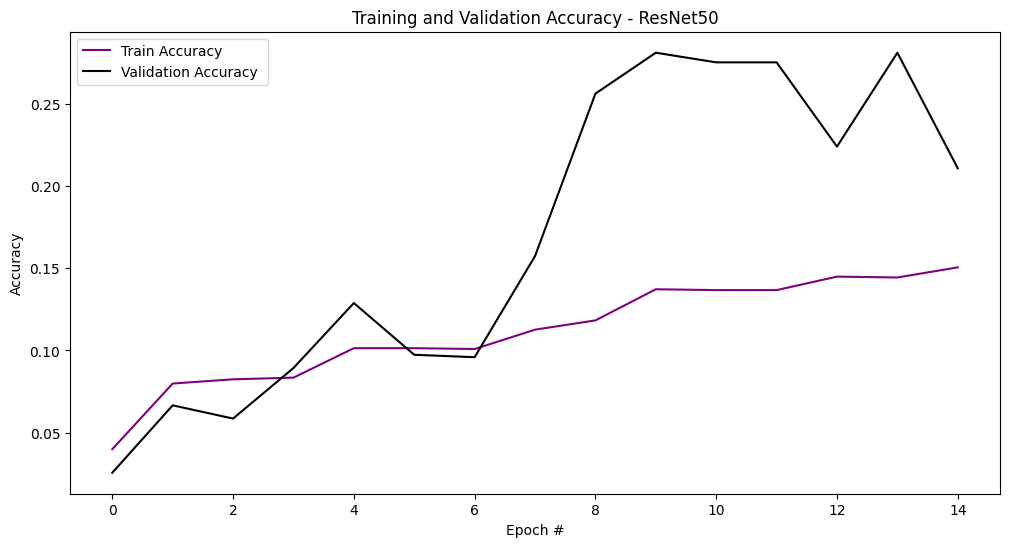

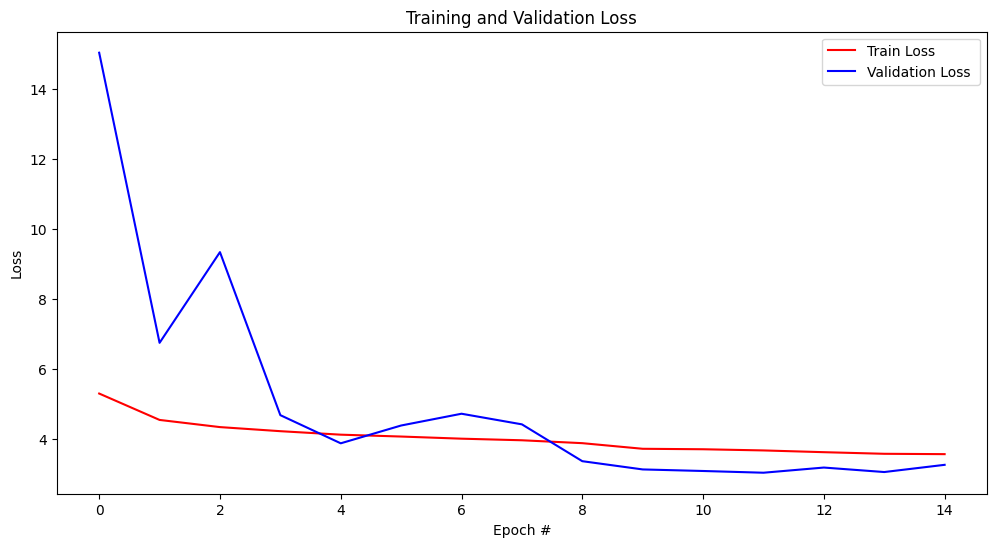

In [9]:
# Graficar Accuracy de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(resnet_history.history["accuracy"], label="Train Accuracy ", color='purple')
plt.plot(resnet_history.history["val_accuracy"], label="Validation Accuracy ", color='black')
plt.title("Training and Validation Accuracy - ResNet50")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Graficar Loss de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(resnet_history.history["loss"], label="Train Loss ", color='red')
plt.plot(resnet_history.history["val_loss"], label="Validation Loss ", color='blue')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

# Desarrollo de la arquitectura - Fine Tuning - ResNet50

In [10]:
# Fine-Tuning (descongelar algunas capas superiores de ResNet50)
resnet_base.trainable = True
resnet_fine_tune_at = 100  # Descongela las capas a partir de la capa 100

for layer in resnet_base.layers[:resnet_fine_tune_at]:
    layer.trainable = False

# Compilar nuevamente con una tasa de aprendizaje baja para el fine-tuning
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning
resnet_history_fine = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=resnet_callbacks
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.0567 - loss: 4.2202
Epoch 1: val_accuracy did not improve from 0.28111
62/62 ━━━━━━━━━━━━━━━━━━━━ 97s 960ms/step - accuracy: 0.0569 - loss: 4.2184 - val_accuracy: 0.0695 - val_loss: 5.8697 - learning_rate: 1.0000e-04
Epoch 2/10
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.0945 - loss: 3.9714
Epoch 2: val_accuracy did not improve from 0.28111
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 651ms/step - accuracy: 0.0946 - loss: 3.9696 - val_accuracy: 0.0608 - val_loss: 5.5460 - learning_rate: 1.0000e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.1118 - loss: 3.8090
Epoch 3: val_accuracy did not improve from 0.28111
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 645ms/step - accuracy: 0.1118 - loss: 3.8091 - val_accuracy: 0.0644 - val_loss: 5.7210 - learning_rate: 1.0000e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.1428 - loss: 3.6787
Epoch 4: val_accuracy did not improve from 0.28111
62/62 ━━━━━━━━━━━━━━━━━━━

# Evaluación y Graficación de Métricas- Fine Tuning - ResNet50

In [11]:
# Evaluación en el conjunto de prueba
resnet_results = resnet_model.evaluate(test_generator, verbose=0)
print(f"ResNet Test Loss: {resnet_results[0]}")
print(f"ResNet Test Accuracy: {resnet_results[1] * 100:.2f}%")

# Generar Reporte de Clasificación
resnet_predictions = resnet_model.predict(test_generator, batch_size=128)
print("Reporte de Clasificación - Fine-Tuning (ResNet):")
print(classification_report(test_generator.classes, resnet_predictions.argmax(axis=1), target_names=test_generator.class_indices.keys()))

ResNet Test Loss: 5.869724273681641
ResNet Test Accuracy: 6.95%
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 265ms/step
Reporte de Clasificación - Fine-Tuning (ResNet):
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.00      0.00      0.00        37
         Adho Mukha Vrksasana       0.00      0.00      0.00        32
                    Alanasana       0.00      0.00      0.00         9
                 Anjaneyasana       0.00      0.00      0.00        35
            Ardha Chandrasana       0.50      0.03      0.06        29
         Ardha Matsyendrasana       0.00      0.00      0.00        48
               Ardha Navasana       0.00      0.00      0.00         6
      Ardha Pincha Mayurasana       0.00      0.00      0.00        27
            Ashta Chandrasana       0.00      0.00      0.00         6
              Baddha Konasana       0.00      0.00      0.00        40
                     Bakasana       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


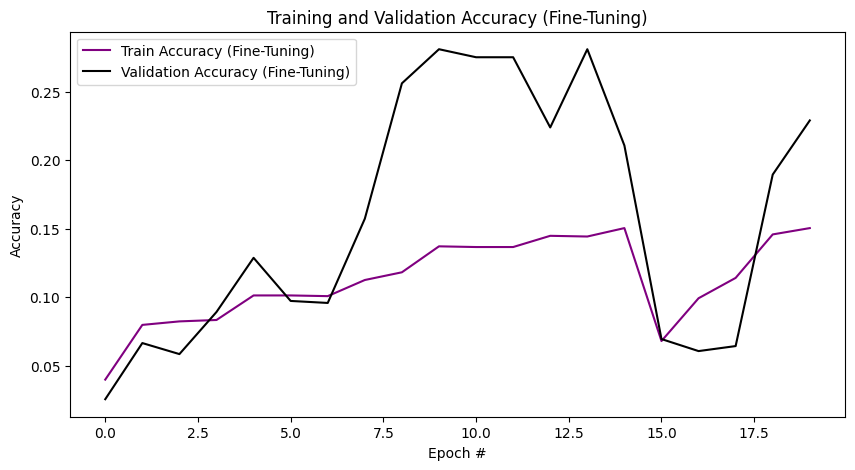

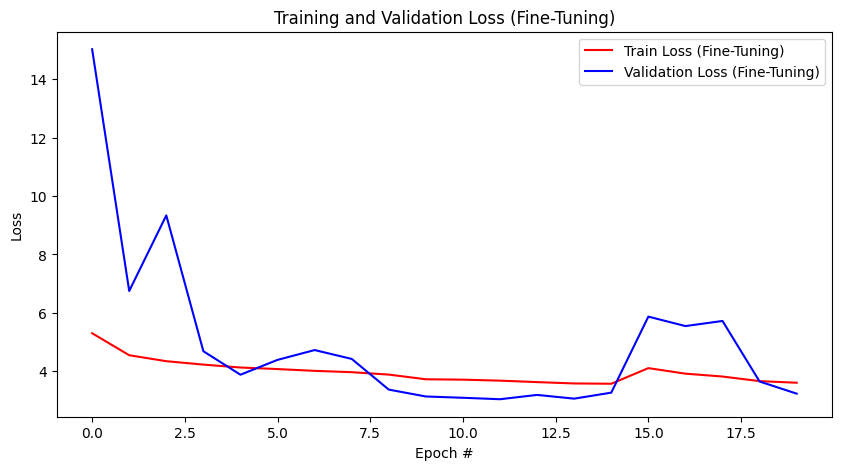

In [19]:
# Graficar precisión de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(resnet_history.history['accuracy'] + resnet_history_fine.history['accuracy'], label="Train Accuracy (Fine-Tuning)", color='purple')
plt.plot(resnet_history.history['val_accuracy'] + resnet_history_fine.history['val_accuracy'], label="Validation Accuracy (Fine-Tuning)", color='black')
plt.title("Training and Validation Accuracy (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Graficar pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(resnet_history.history['loss'] + resnet_history_fine.history['loss'], label="Train Loss (Fine-Tuning)", color='red')
plt.plot(resnet_history.history['val_loss'] + resnet_history_fine.history['val_loss'], label="Validation Loss (Fine-Tuning)", color='blue')
plt.title("Training and Validation Loss (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()